In [1]:
%load_ext autoreload
%autoreload 2

import cv2
from pathlib import Path
import numpy as np

from robustpca.general import ROOT_DIR

In [2]:
yale_data_dir  = Path(ROOT_DIR, 'data', 'CroppedYale')
assert yale_data_dir.exists()

In [3]:
human_id = np.random.randint(0, len(list(yale_data_dir.glob('*'))))

print(f'Subject: {human_id}')

faces = []
for face_path in sorted(list(yale_data_dir.glob('*'))[human_id].glob('*.pgm'))[:-1]:
    arr = cv2.imread(face_path.as_posix())[:, :, 0]
    faces.append(arr)

Subject: 32


In [4]:
import random

random.shuffle(faces)
len(faces)

64

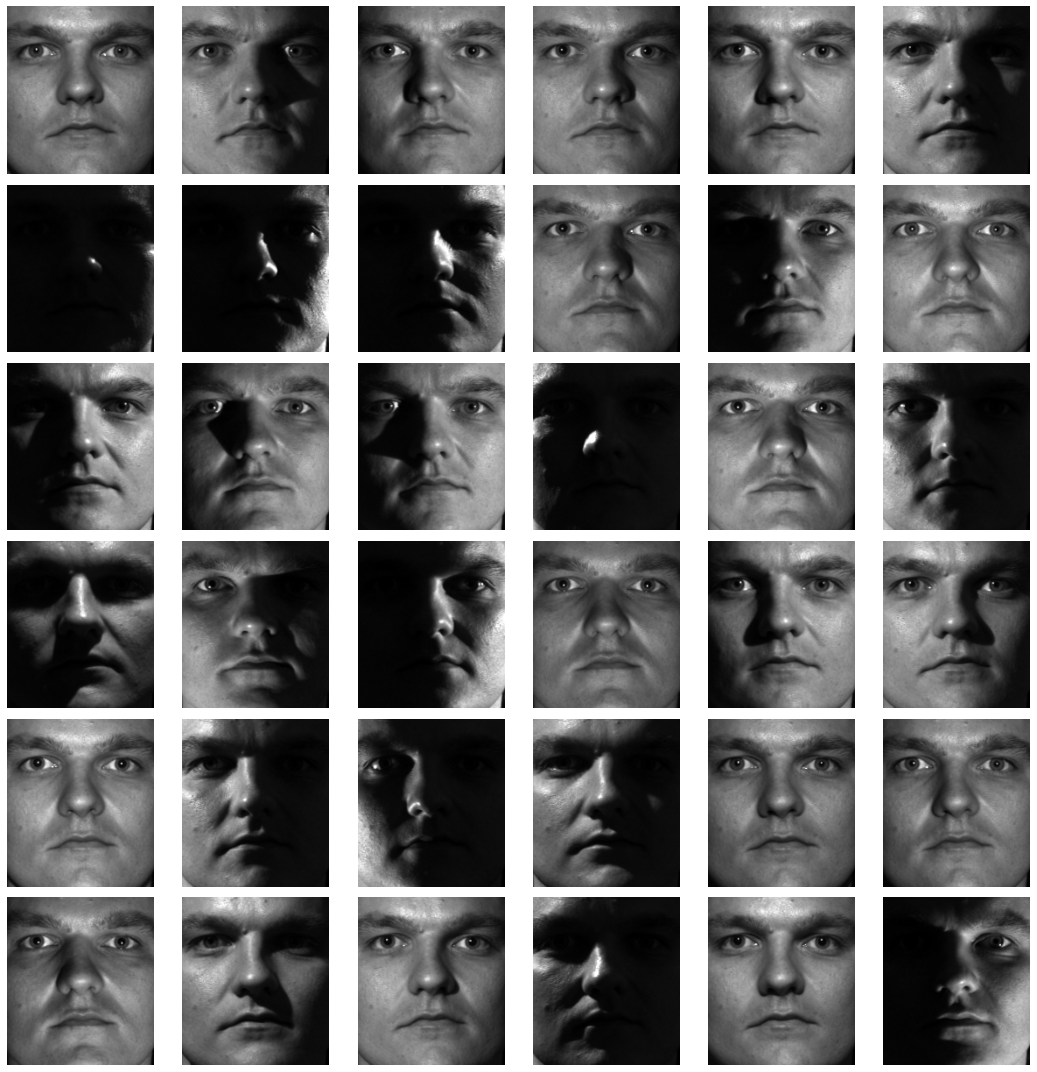

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(6, 6, figsize=(15, 15))

for ax in axs.flatten():
    ax.axis('off')

for i, ax in enumerate(axs.flatten()):
    ax.imshow(faces[i], cmap='gray')

fig.tight_layout()

In [6]:
data_mat = np.stack(faces, -1).reshape(-1, len(faces))
data_mat.shape

(32256, 64)

In [7]:
from robustpca.pcp import PCP
from robustpca.pcp import StablePCP

In [8]:
pcp_alm = PCP()
mu = pcp_alm.default_mu(data_mat)
L_pcp, S_pcp = pcp_alm.decompose(data_mat, mu, tol=1e-5)

Elapsed: 78.75


In [9]:
f'intrisic rank: {np.linalg.matrix_rank(L_pcp)}, original rank: {np.linalg.matrix_rank(data_mat)}, fraction of outliers: {(S_pcp != 0).mean():.3f}'

'intrisic rank: 30, original rank: 64, fraction of outliers: 0.780'

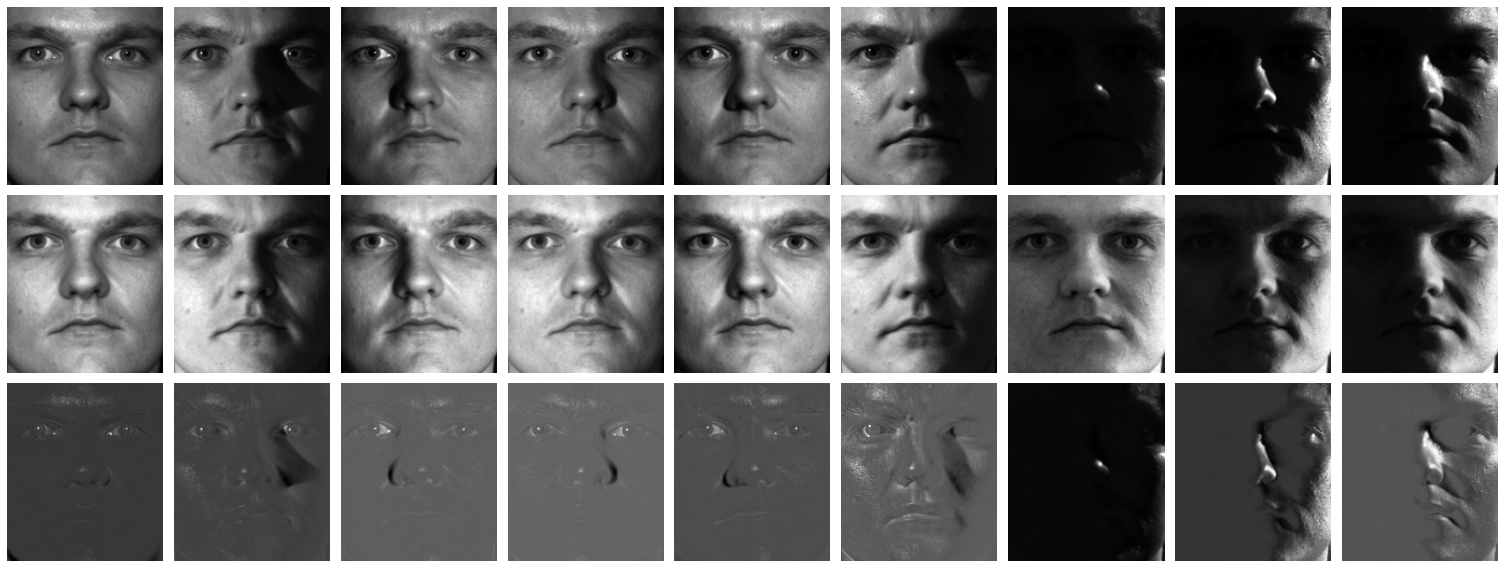

In [10]:
from matplotlib import pyplot as plt

ncols = 9
fig, axs = plt.subplots(3, ncols, figsize=(21, 8))

for ax in axs.flatten():
    ax.axis('off')

for i in range(ncols):
    without_shadow = L_pcp[:, i].reshape(faces[i].shape)
    shadow = S_pcp[:, i].reshape(faces[i].shape)
    axs[0, i].imshow(faces[i], cmap='gray')
    axs[1, i].imshow(without_shadow, cmap='gray')
    axs[2, i].imshow(shadow, cmap='gray')

fig.tight_layout()

In [11]:
pcp_alm = StablePCP()
mu = pcp_alm.default_mu(data_mat, sigma=10)
L_st_pcp, S_st_pcp = pcp_alm.decompose(data_mat, mu, tol=1e-5)

Elapsed: 17.92


In [12]:
f'intrisic rank: {np.linalg.matrix_rank(L_st_pcp)}, original rank: {np.linalg.matrix_rank(data_mat)}, fraction of outliers: {(S_st_pcp != 0).mean():.3f}'

'intrisic rank: 7, original rank: 64, fraction of outliers: 0.092'

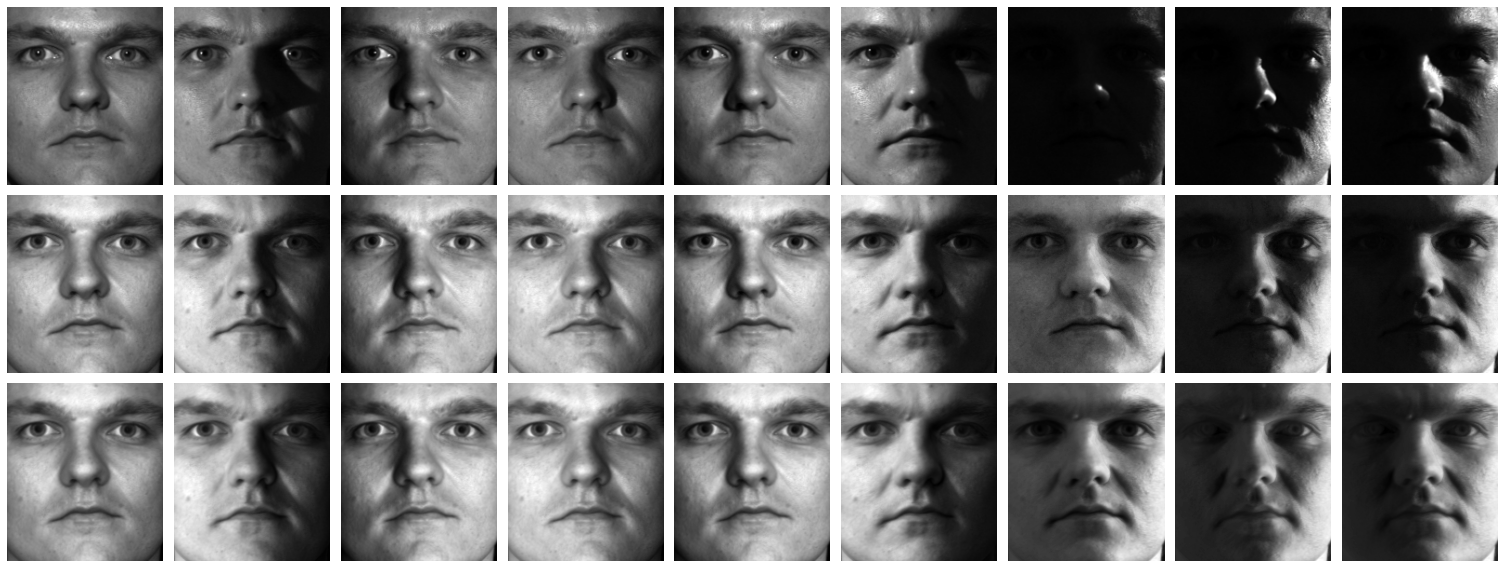

In [13]:
from matplotlib import pyplot as plt

ncols = 9
fig, axs = plt.subplots(3, ncols, figsize=(21, 8))

for ax in axs.flatten():
    ax.axis('off')

for i in range(ncols):
    axs[0, i].imshow(faces[i], cmap='gray')
    without_shadow = L_pcp[:, i].reshape(faces[i].shape)
    axs[1, i].imshow(without_shadow, cmap='gray')
    without_shadow = L_st_pcp[:, i].reshape(faces[i].shape)
    axs[2, i].imshow(without_shadow, cmap='gray')

fig.tight_layout()

In [14]:
from robustpca.ircur import IRCUR

In [15]:
pcp_alm = IRCUR()
rank = 8
c = 4
nrows, ncols = int(c * rank * np.log(data_mat.shape[0])), int(c * rank * np.log(data_mat.shape[1]))
L_ircur, S_ircur = pcp_alm.decompose(data_mat, rank, nrows, ncols, thresholding_decay=0.9, initial_threshold=100, verbose=True)

Iteration: 112, diff: 9.87968637888015e-06, terminating alg.
Elapsed: 34.35


In [16]:
f'intrisic rank: {np.linalg.matrix_rank(L_ircur)}, original rank: {np.linalg.matrix_rank(data_mat)}, fraction of outliers: {(S_ircur != 0).mean():.3f}'

'intrisic rank: 8, original rank: 64, fraction of outliers: 0.993'

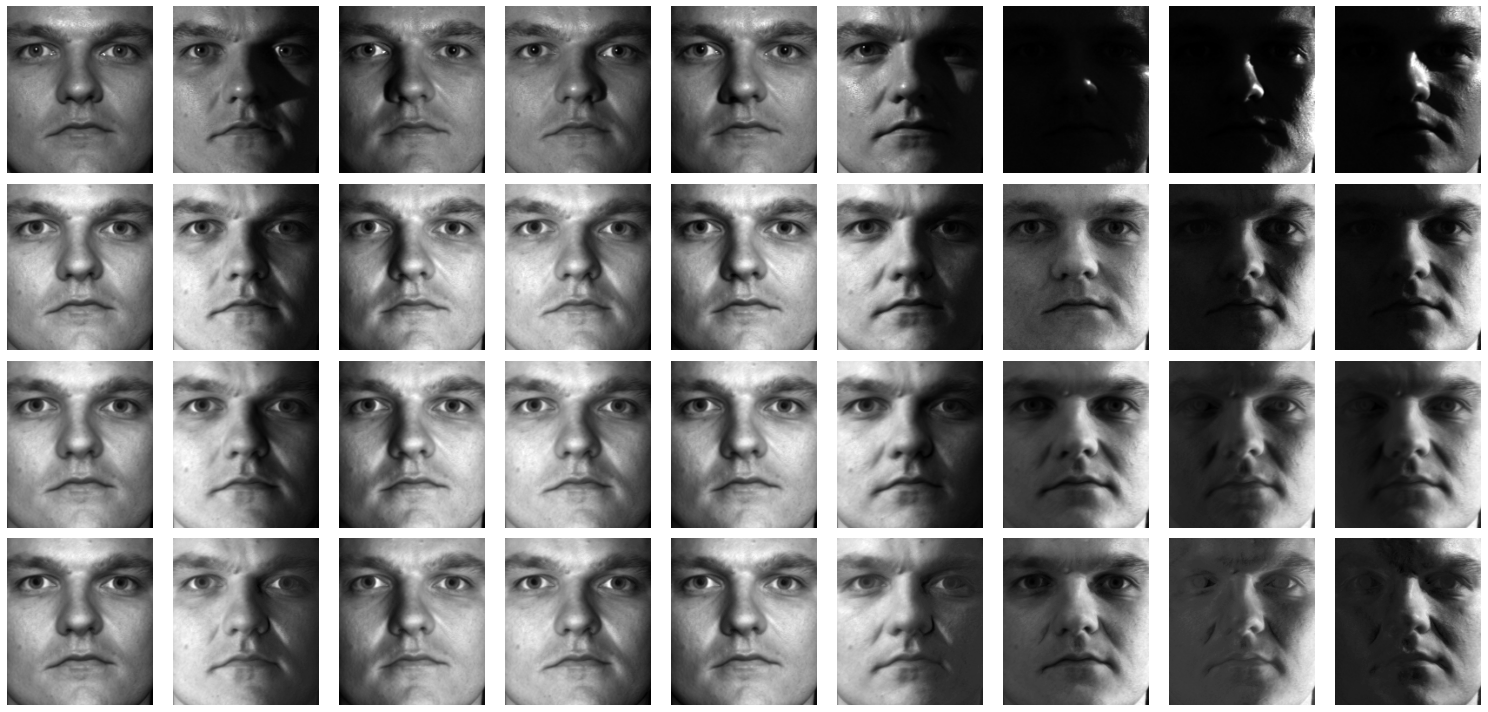

In [17]:
from matplotlib import pyplot as plt

ncols = 9
fig, axs = plt.subplots(4, ncols, figsize=(21, 10))

for ax in axs.flatten():
    ax.axis('off')

for i in range(ncols):
    axs[0, i].imshow(faces[i], cmap='gray')
    without_shadow = L_pcp[:, i].reshape(faces[i].shape)
    axs[1, i].imshow(without_shadow, cmap='gray')
    without_shadow = L_st_pcp[:, i].reshape(faces[i].shape)
    axs[2, i].imshow(without_shadow, cmap='gray')
    without_shadow = L_ircur[:, i].reshape(faces[i].shape)
    axs[3, i].imshow(without_shadow, cmap='gray')
    # shadow = S_ircur[:, i].reshape(faces[i].shape)
    # axs[2, i].imshow(shadow, cmap='gray')

fig.tight_layout()